# Proxy-метрики

## Описание задачи

Для любого классифайда ключевой целью пользователей является завершение сделки между продавцом и покупателем. 

Часто на стороне классифайда завершение сделки не фиксируется, но замерять эту метрику менеджеры хотят, чтобы понимать, лучше или хуже в динамике их продукт помогает покупке/продаже автомобилей. Аналитикам нужно придумать, как замерять завершение сделки в динамике. Кажется, что если это не на стороне классифайда, то возможно, стоит обзвонить пользователей и поинтересоваться, продали они свои автомобили или нет. Так получится найти долю пользователей, которые по-настоящему продали автомобиль. В кейсе автоклассифайда так и было: аналитики инициировали обзвон продавцов, чьи объявления были активны, а потом через некоторое время пропали с сайта, ушли в архив. В опросе у каждого продавца спрашивали, удалось ли ему продать автомобиль, а, если удалось, то на какой площадке. Так появился размеченный датасет с точным замером требуемой метрики: конкретные объявления, конкретные пользователи и информация о том, состоялась продажа автомобиля или нет.

В кейсе мы придумаем ряд метрик, которые могут быть кандидатами на роль proxy-метрики. Проведем корреляционный анализ и попробуем в рамках A/B-теста найти причинно-следственную связь, посмотреть, как ведет себя гипотеза в проверке на proxy-метрике, действительно ли она дает сонаправленный ответ, какой давал бы A/B-тест, если бы его проводили на целевой метрике?

## Исходные данные
Есть датасет proxy_metrics_case_data.csv, который был получен после обзвона. В этом датасете каждая из 1200 строк соответствует одному объявлению, которое находилось в продаже, но потом ушло в архив.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

### Загрузим данные

In [2]:
data = pd.read_csv('data/proxy_metrics_case_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   views                1200 non-null   int64  
 1   contacts             1200 non-null   int64  
 2   last_7_views         1200 non-null   int64  
 3   last_3_views         1200 non-null   int64  
 4   last_7_contacts      1200 non-null   int64  
 5   last_3_contacts      1200 non-null   int64  
 6   live_days            1200 non-null   int64  
 7   max_messages_events  1200 non-null   int64  
 8   messages_events      1200 non-null   int64  
 9   messages_users       1200 non-null   int64  
 10  avg_contacts_delta   1200 non-null   float64
 11  max_contacts_delta   1200 non-null   int64  
 12  min_contacts_delta   1200 non-null   int64  
 13  is_selling_2         1200 non-null   object 
 14  mumur_advertid       1200 non-null   int64  
dtypes: float64(1), int64(13), object(1)
me

In [3]:
data.head()

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,is_selling_2,mumur_advertid
0,84,2,84,39,2,2,8,0,0,0,0.00,2,-2,Yes,1491863013
1,95,0,95,36,0,0,8,0,0,0,0.00,0,0,Yes,1909318556
2,118,3,118,40,3,2,8,0,0,0,0.17,1,-1,Yes,898271490
3,11,0,11,2,0,0,7,0,0,0,0.00,0,0,Yes,4050431016
4,48,2,48,8,2,0,8,0,0,0,0.00,0,0,Yes,452654590


## Алгоритм для работы с прокси-метриками
1. Найти хороших кандидатов на прокси-метрики;
2. Провести корреляционный анализ;
3. Доработать первичный список;
4. Проверить мощность и уровень значимости теста;
5. Проверить на реальном АБ-тесте, позволяет ли прокси-метрика детектить изменение целевой метрики
6. Анализ чувствительности прокси-метрики.

### Шаг 1. Проверяем наличие корреляции

Искать корреляции можно разными способами: через использование t-теста, критерия Манна-Уитни и корреляции Пирсона и даже построения уравнения регрессии:
* T-тест и критерий Манна-Уитни позволяют выявить связь между двумя группами. 
* T-test сравнивает средние значения групп между двумя группами (категориальная переменная). 
* Манна-Уитни делает похожую задачу, но при этом преобразуя данные в ранговое пространство. Из-за этого мы уже напрямую средние не сравниваем.

{'point_biserial_R': 0.19401064582973587,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

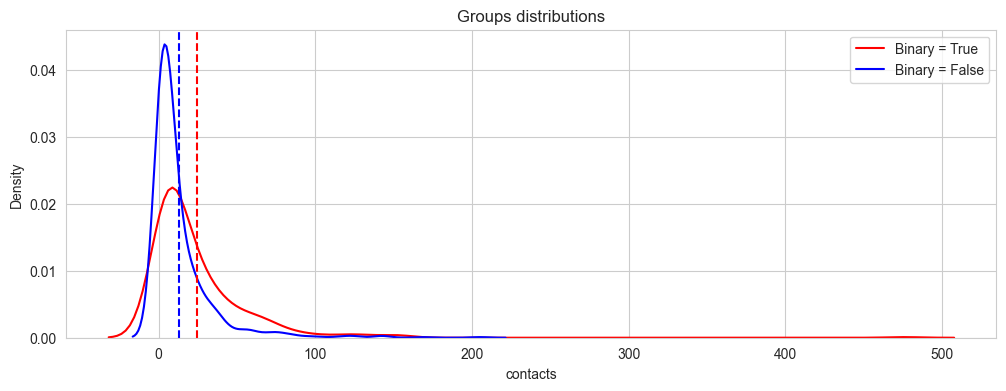

In [4]:
from savvy import proxy_metrics
proxy_metrics.find_correlation_CQ_vars(quant_value=data['contacts'], binary_mask=data['is_selling_2']=='Sold', plot=True)

На графике мы видим график плотности распределений для контактов по проданным (красный) и непроданным объявлениям (синий) и средние по каждой группе.

In [5]:
proxy_metrics.find_correlation_CQ_vars(quant_value=data['contacts'], binary_mask=data['is_selling_2']=='Sold', show_conclusion=True)

Mean quant value for group (binary=1) = 24.284671532846716
Mean quant value for group (binary=0) = 13.135614702154626
Median quant value for group (binary=1) = 12.0
Median quant value for group (binary=0) = 6.0
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2166186100304946e-11
point biserial correlation = 0.19401064582973587


{'point_biserial_R': 0.19401064582973587,
 'kruskal_pval': 9.980588061981067e-19,
 'ttest_pval': 1.2166186100304946e-11}

По результатам стат тестов мы можем сказать следующее: видна слабая точечно-бисерийная корреляция между переменными. А p-value говорит нам о том, что предварительно нулевая гипотеза отклоняется.

### Ищем пороги для прокси-метрики на примере переменной "Просмотры"
Посмотрим, есть ли различия в распределении просмотров в зависимости от того, продали ли авто или нет.

Mean quant value for group (binary=1) = 1017.3844282238443
Mean quant value for group (binary=0) = 732.106463878327
Median quant value for group (binary=1) = 500.0
Median quant value for group (binary=0) = 368.0
Kruskal-Wallis H Test p-value = 0.00011486887007781793
T-test p-value = 0.00018505614391999974
point biserial correlation = 0.10772185104605939


0.10772185104605939

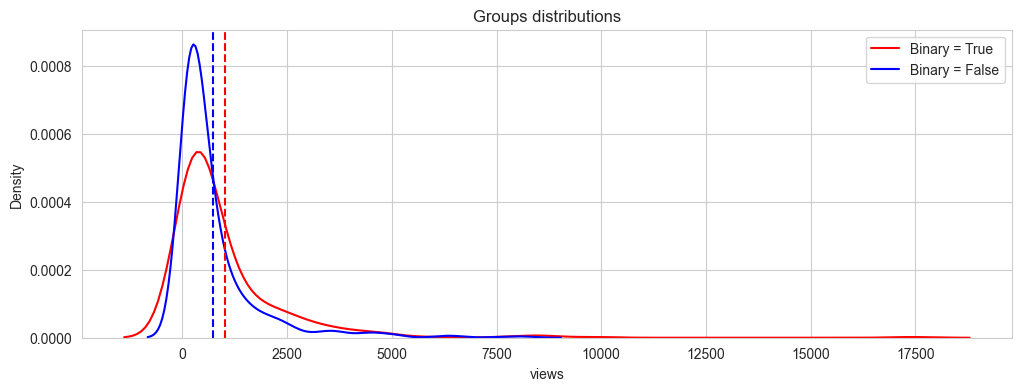

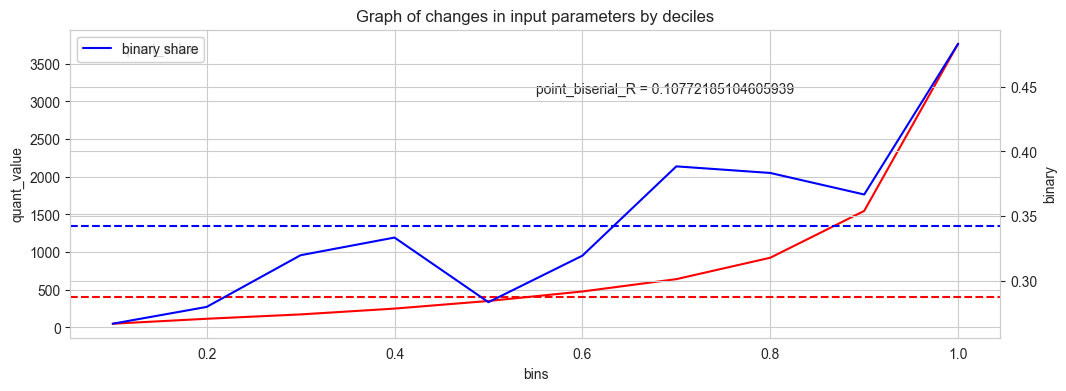

In [6]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=data['views'], binary_mask=data['is_selling_2']=='Sold', step = 0.1, plot=True)

Эта функция нужна для поиска порога, то есть с какого значения количественной метрики конверсия резко увеличивается или уменьшается. Видим, что распределения и средние явно различаются (стат критерии показывают различия в средних), но корреляция недостаточно высокая.
Значение шага в 0.1 показывает, что мы проводим децильный анализ. Красная линия - это среднее значение в группе по количественной метрике (quant_value), синяя - по категориальному параметру (продал или нет, конверсия, binary). То есть вывод% с ростом количественной метрики конверсия растет. 

### Рассмотрим метрику Cуммарные контакты

Мера различий между группами (p-value в критериях) выглядит более значимой. Так же, как и уровень корреляции. Значит, мы двигаемся в правильном направлении.

Mean quant value for group (binary=1) = 24.284671532846716
Mean quant value for group (binary=0) = 13.135614702154626
Median quant value for group (binary=1) = 12.0
Median quant value for group (binary=0) = 6.0
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2166186100304946e-11
point biserial correlation = 0.19401064582973587


0.19401064582973587

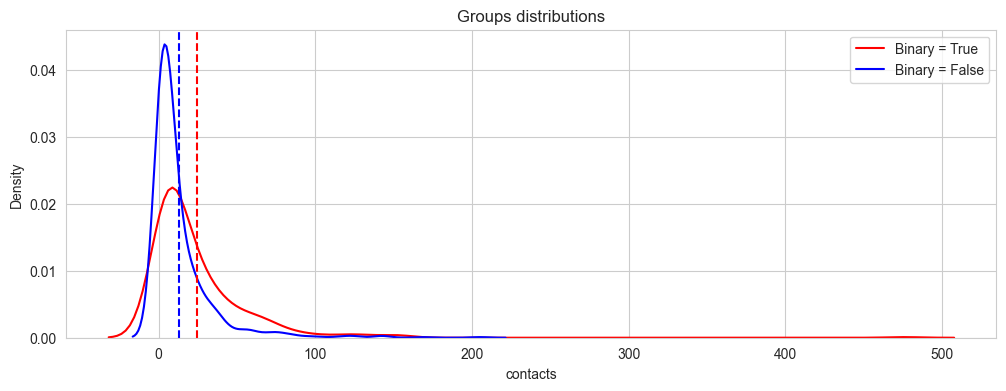

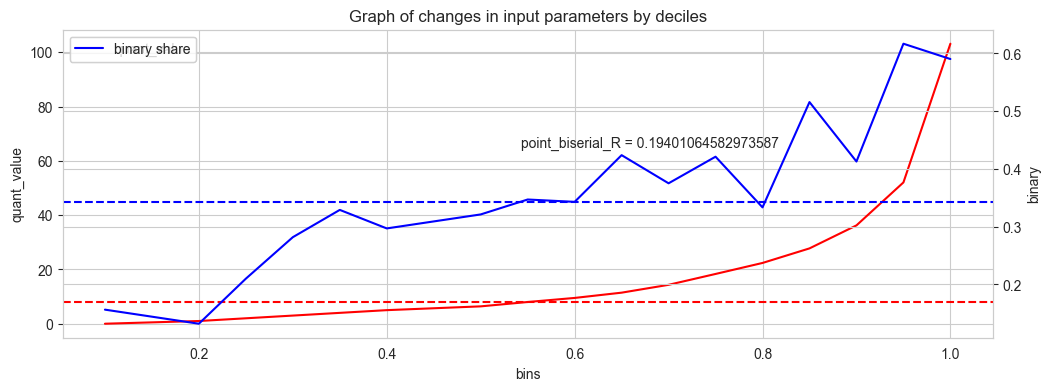

In [7]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=data['contacts'], binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Видно, что между контактами и долей проданных автомобилей есть корреляция

### Преобразуем немного метрику контактов

Mean quant value for group (binary=1) = 2.6186976747923767
Mean quant value for group (binary=0) = 1.9687405430469174
Median quant value for group (binary=1) = 2.5649493574615367
Median quant value for group (binary=0) = 1.9459101490553132
Kruskal-Wallis H Test p-value = 9.980588061981067e-19
T-test p-value = 1.2127397196980984e-19
point biserial correlation = 0.25760737743473794


0.25760737743473794

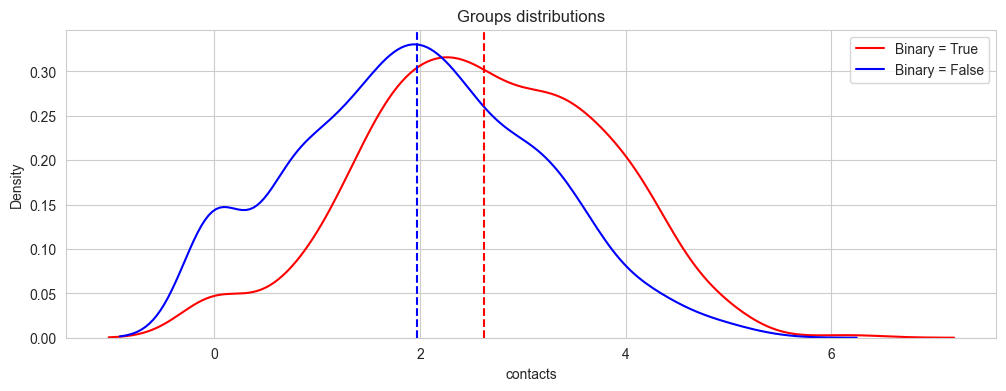

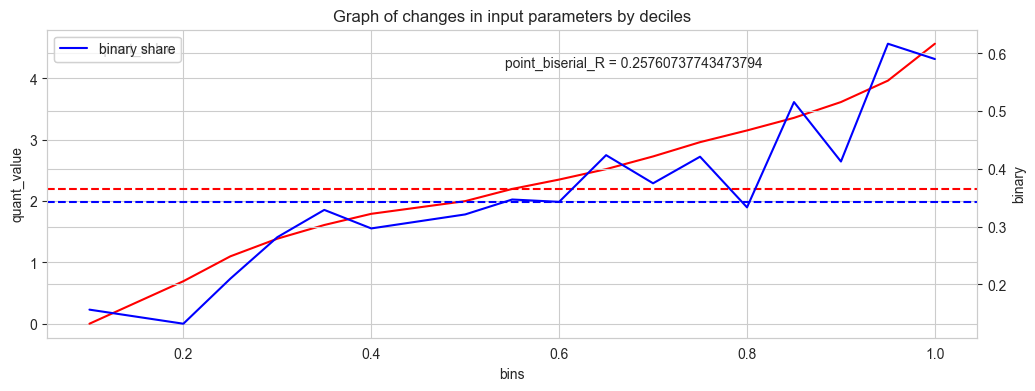

In [8]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

После преобразования метрики контактов корреляция стала видна еще сильнее. То, что логарифм работает на корреляцию лучше, говорит о том, что вероятность сконтактировать прирастает нелинейно от количества контактов.

### Рассмотрим метрику live days

Кажется, что количество проведенных в листинге дней также должно повышать вероятность продажи. Давайте рассмотрим, как эта метрика влияет на вероятность продажи.

Mean quant value for group (binary=1) = 10.150851581508515
Mean quant value for group (binary=0) = 12.724968314321927
Median quant value for group (binary=1) = 8.0
Median quant value for group (binary=0) = 8.0
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 7.710755933111699e-06
point biserial correlation = -0.12872277961206396


-0.12872277961206396

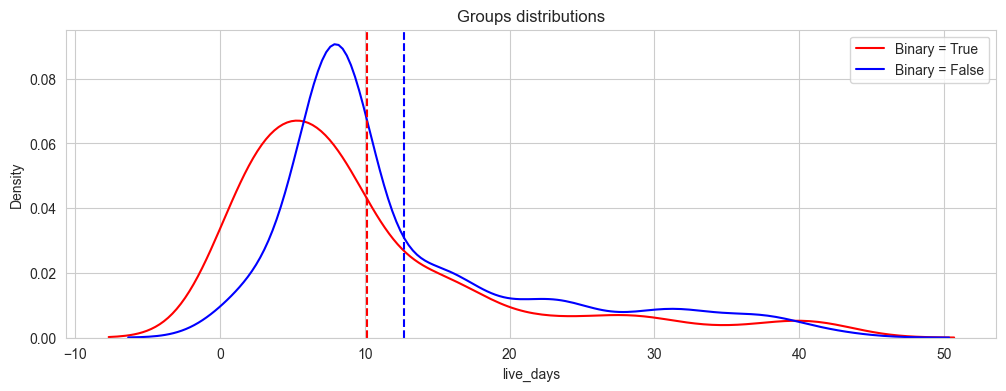

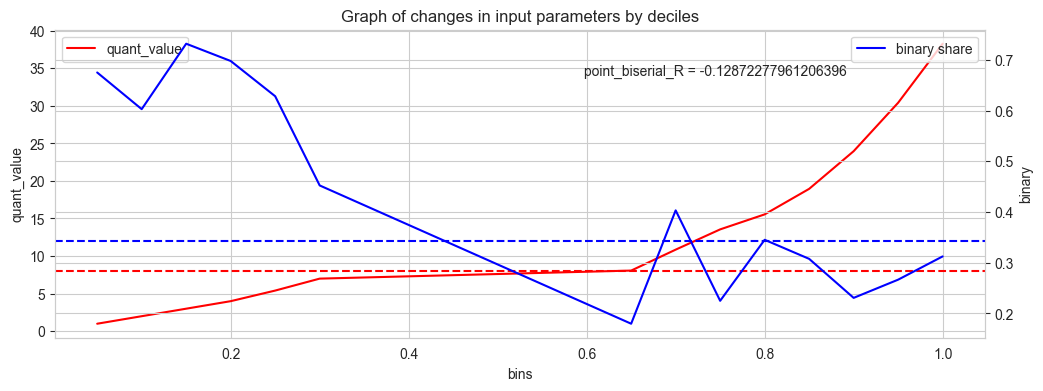

In [9]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=data['live_days'], binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Видно, что длительность пребывания в live влияет на вероятность продать автомобиль. При этом вероятность падает с ростом длительности присутствия в live. Также кажется, что влияние длительности нелинейное, поэтому попробуем преобразовать метрику.

Mean quant value for group (binary=1) = 1.9036491164063059
Mean quant value for group (binary=0) = 2.303250317193941
Median quant value for group (binary=1) = 2.0794415416798357
Median quant value for group (binary=0) = 2.0794415416798357
Kruskal-Wallis H Test p-value = 1.1322319834713854e-14
T-test p-value = 6.349534248658027e-16
point biserial correlation = -0.23041309666831866


-0.23041309666831866

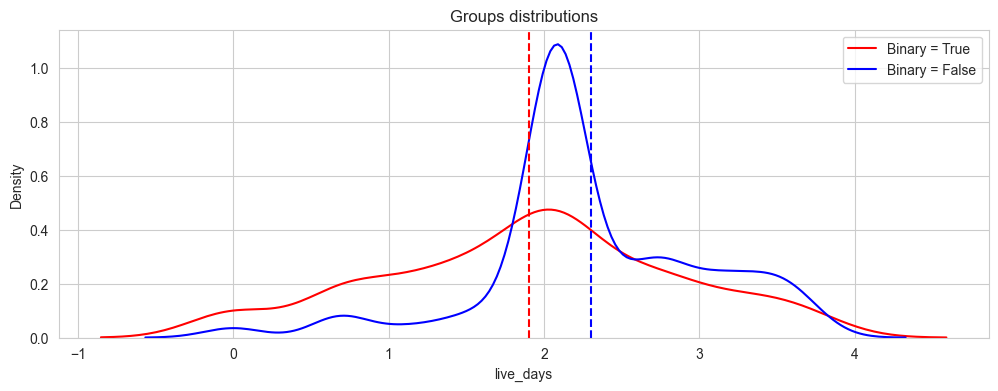

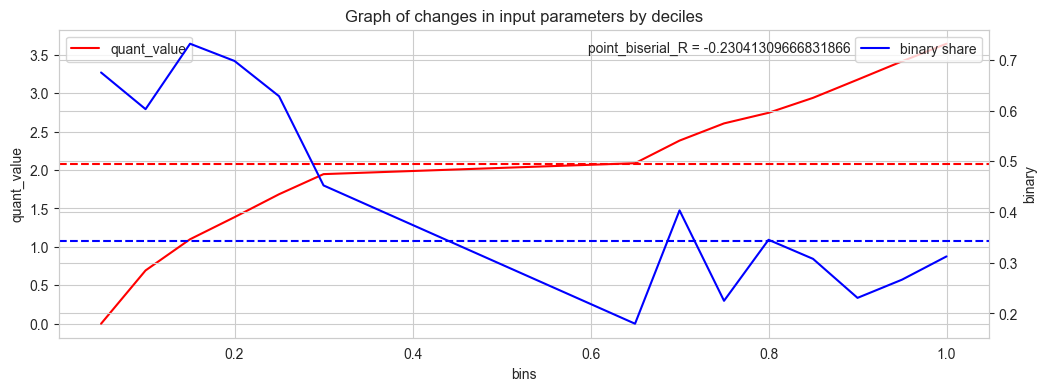

In [10]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['live_days']), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Видим, что метрика длительности пребывания в тесте важная для определения вероятности совершения продажи. Но сама по себе все еще несет не достаточно сильную корреляцию.

### Рассмотрим соотношение контактов к просмотрам

Кажется, что хорошим кандидатом на прокси-метрику, предсказывающим вероятность совершения контактов может быть соотношение контактов к просмотрам у объявления. "Хорошее" объявление должно набирать большее кол-во контактов на объем просмотров. Проверим это предположение.

Mean quant value for group (binary=1) = 0.03451658873478254
Mean quant value for group (binary=0) = 0.022656793552670387
Median quant value for group (binary=1) = 0.02557544757033248
Median quant value for group (binary=0) = 0.015267175572519083
Kruskal-Wallis H Test p-value = 2.1088451078274545e-17
T-test p-value = 9.972214444692406e-11
point biserial correlation = 0.18527145231954215


0.18527145231954215

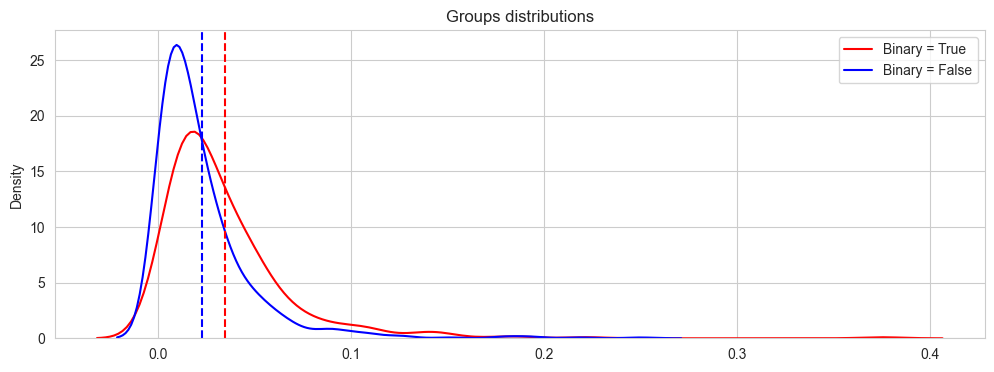

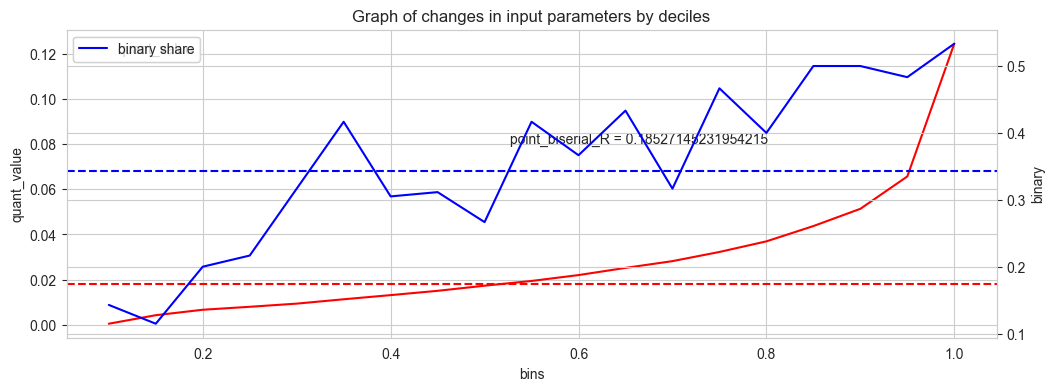

In [11]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=data['contacts']/(data['views']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Mean quant value for group (binary=1) = 0.4112297878708361
Mean quant value for group (binary=0) = 0.317059106268378
Median quant value for group (binary=1) = 0.42847699432180264
Median quant value for group (binary=0) = 0.3366397090051905
Kruskal-Wallis H Test p-value = 8.477260202121721e-24
T-test p-value = 1.1027753513094165e-22
point biserial correlation = 0.2776689337022369


/Users/a_oronovskaya/Documents/GitHub/savvy/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2776689337022369

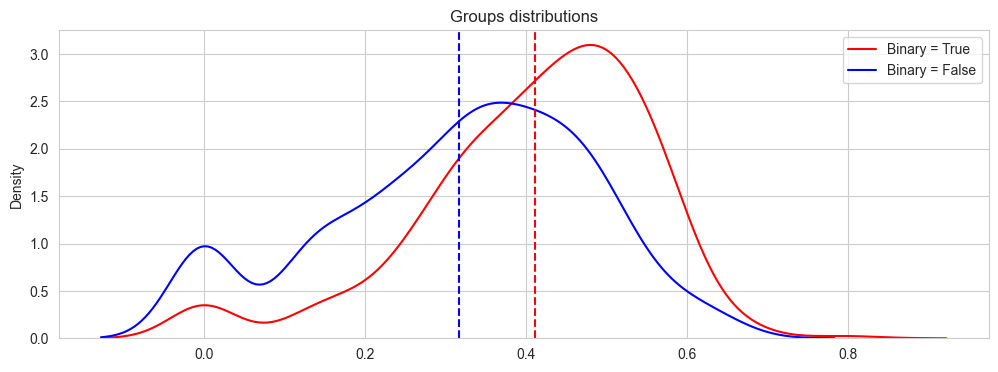

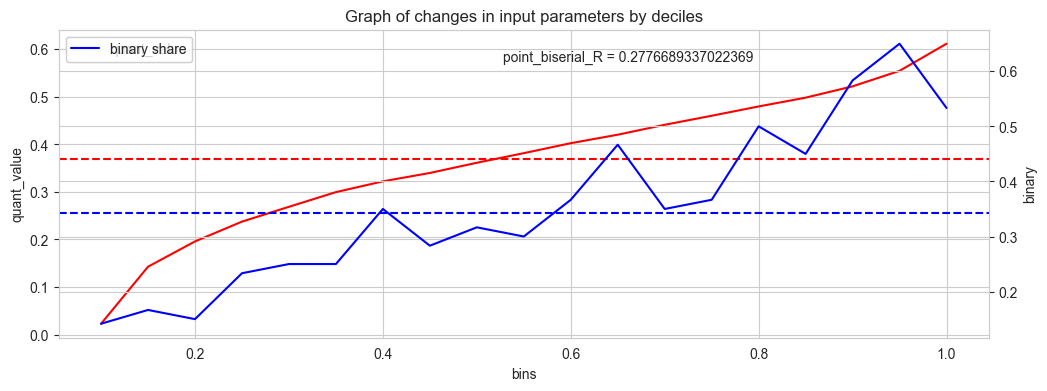

In [12]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['contacts']+1) / np.log(data['views']), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

### Рассмотрим скорость набора контактов (в зависимости от кол-ва дней в live)

Кажется, что чем быстрее объявление набирает контакты, тем вероятнее произойдет продажа. Проверим это предположение.

Mean quant value for group (binary=1) = 2.7854726838806743
Mean quant value for group (binary=0) = 1.1170922804394385
Median quant value for group (binary=1) = 1.6666666666666667
Median quant value for group (binary=0) = 0.6428571428571429
Kruskal-Wallis H Test p-value = 4.811812489816918e-44
T-test p-value = 1.5839426375159415e-35
point biserial correlation = 0.34817978023220486


0.34817978023220486

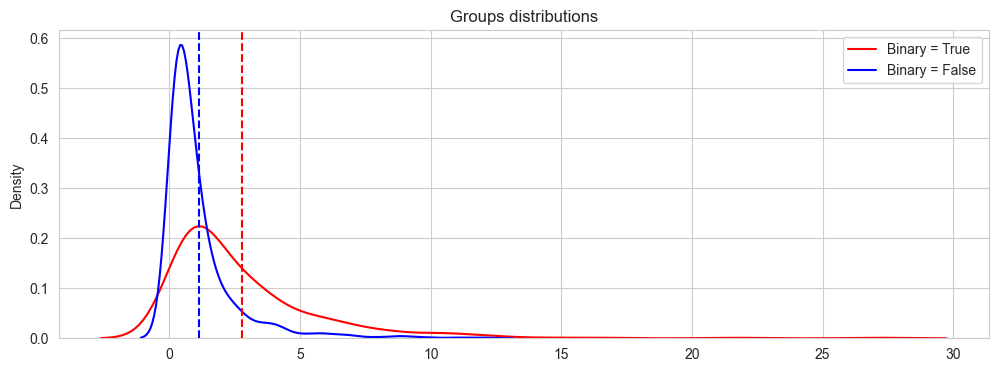

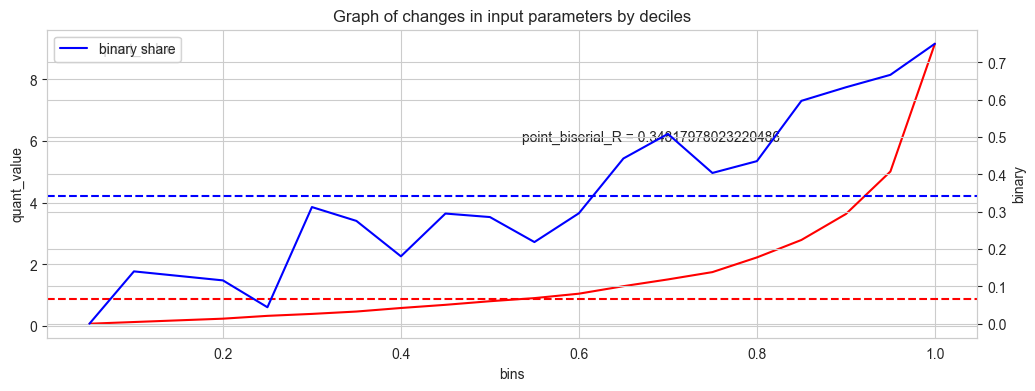

In [13]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=(data['contacts']+1) / (data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Mean quant value for group (binary=1) = 1.3844308113070027
Mean quant value for group (binary=0) = 0.8324681613360103
Median quant value for group (binary=1) = 1.2920296742201791
Median quant value for group (binary=0) = 0.8154648767857287
Kruskal-Wallis H Test p-value = 2.8757349732621836e-45
T-test p-value = 2.234162988320111e-44
point biserial correlation = 0.38790804059987655


0.38790804059987655

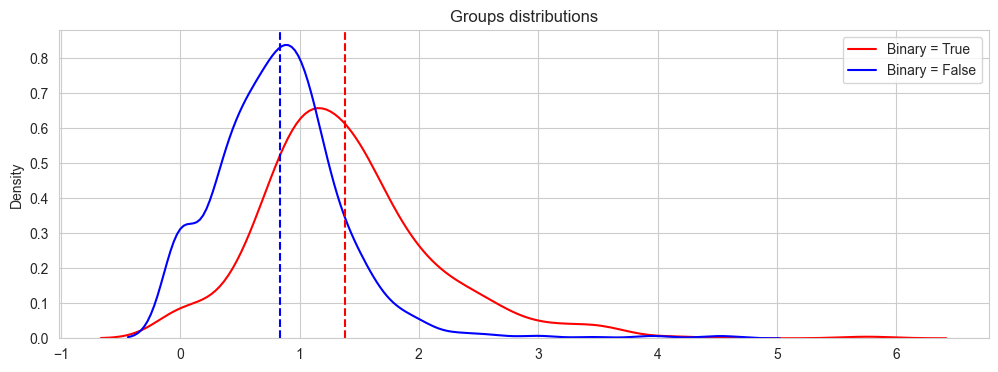

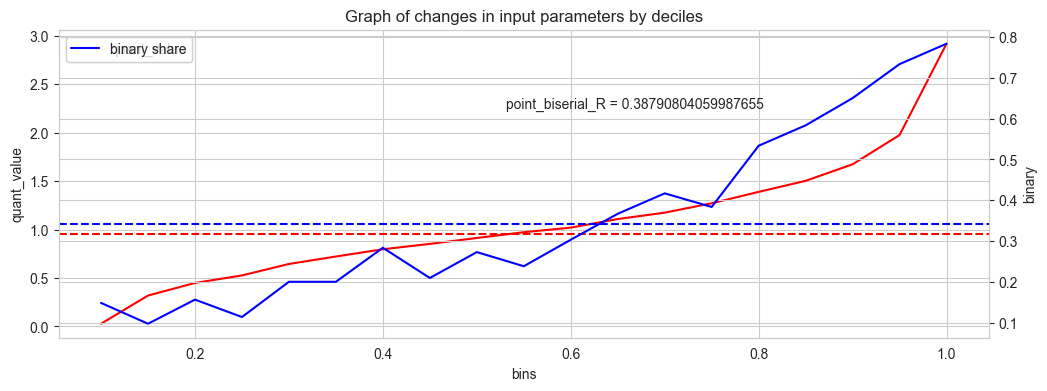

In [14]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['contacts']+1) / np.log(data['live_days']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

### Рассмотрим метрику контакты за последние несколько дней перед уходом в архив

Метрика набора контактов за последние три дня сочетает в себе и подсчет контактов, и метрику скорости. Посмотрим, будет ли это хорошим кандидатом на эту роль

Mean quant value for group (binary=1) = 16.124087591240876
Mean quant value for group (binary=0) = 7.108998732572877
Median quant value for group (binary=1) = 10.0
Median quant value for group (binary=0) = 4.0
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 4.1409370143423566e-23
point biserial correlation = 0.2803453016021142


0.2803453016021142

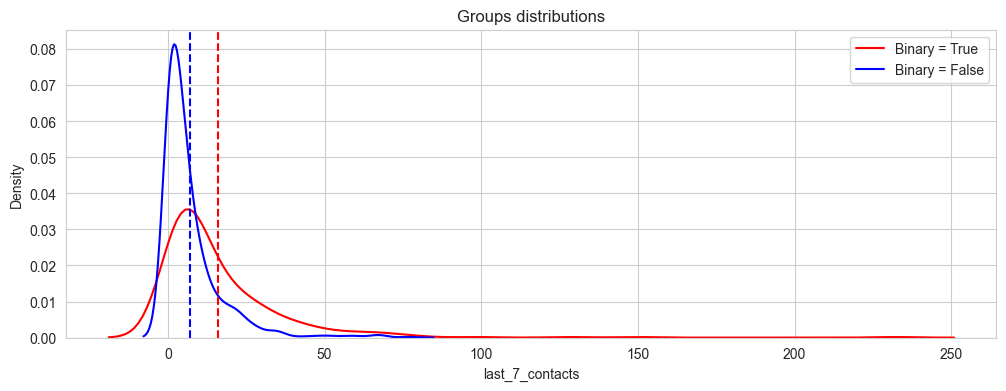

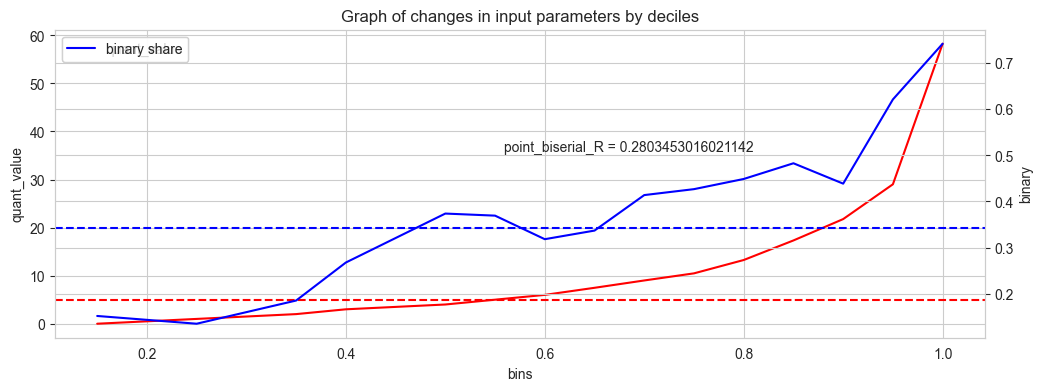

In [15]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=data['last_7_contacts'], binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Попробуем логарифмировать

Mean quant value for group (binary=1) = 2.3224548692436144
Mean quant value for group (binary=0) = 1.5626914772082996
Median quant value for group (binary=1) = 2.3978952727983707
Median quant value for group (binary=0) = 1.6094379124341003
Kruskal-Wallis H Test p-value = 3.1821541212660747e-29
T-test p-value = 1.7156887701776706e-31
point biserial correlation = 0.32799583538148497


0.32799583538148497

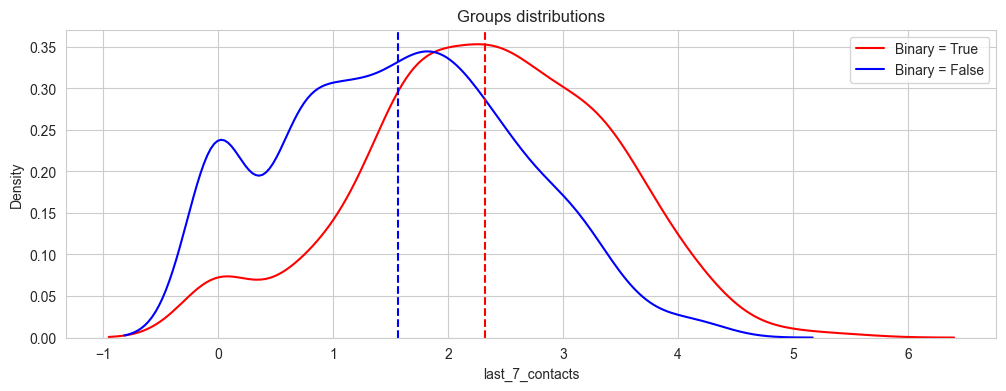

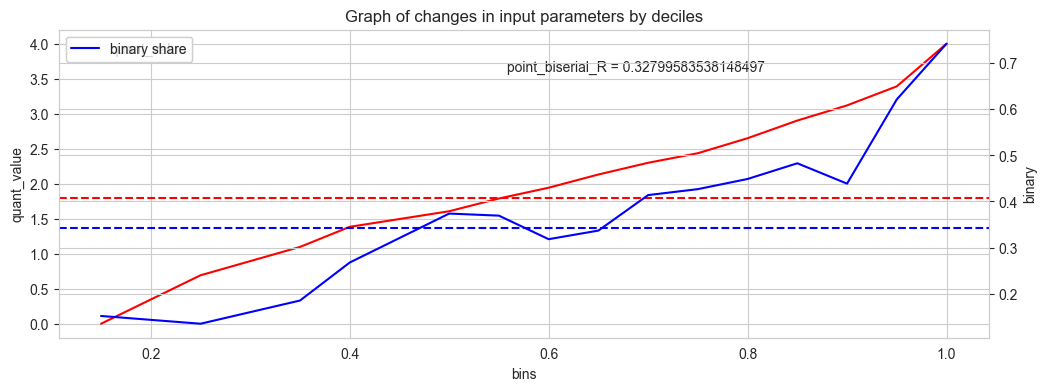

In [16]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['last_7_contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

На графике явно видно, что группа, продавшая авто, получала перед уходом в архив больше контактов. И при этом доля тех, кто получил контактов больше 0 у "продавших" значительно ниже

Mean quant value for group (binary=1) = 1.89373516861593
Mean quant value for group (binary=0) = 0.9443381111904845
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 1.1733129557672549e-45
T-test p-value = 6.05383456974365e-52
point biserial correlation = 0.418002461974441


0.418002461974441

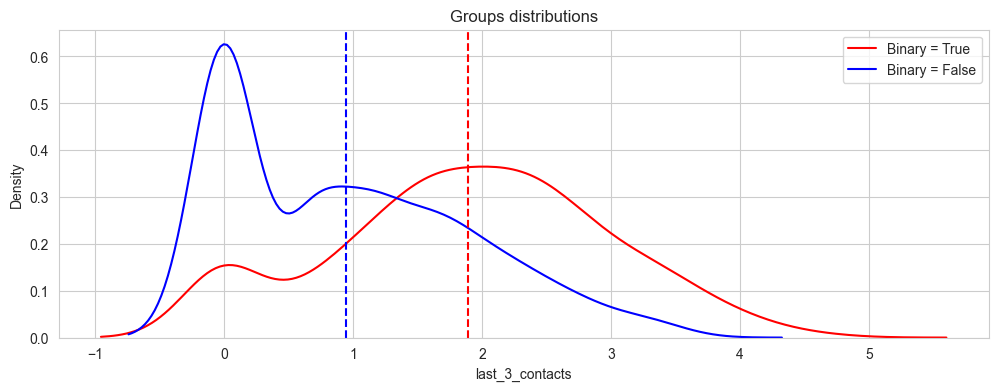

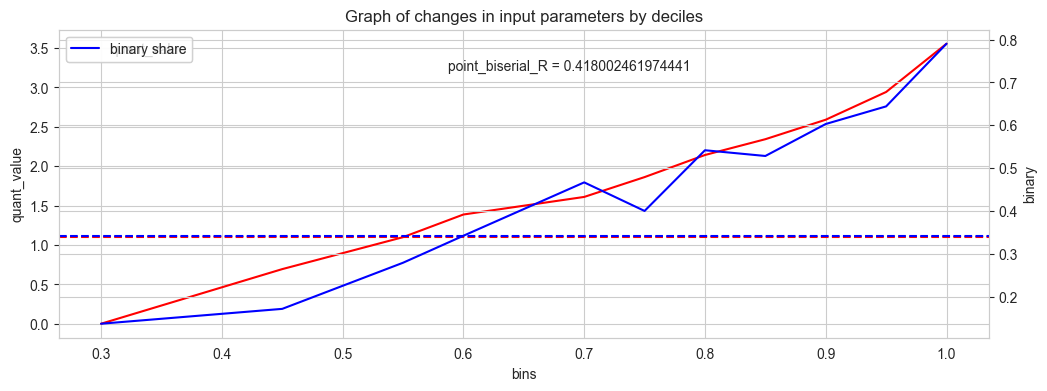

In [17]:
proxy_metrics.proxy_metrics_bins_analyzer(quant_value=np.log(data['last_3_contacts']+1), binary_mask=data['is_selling_2']=='Sold', step = 0.05, plot=True)

Мы нашли неплохого кандидата на роль прокси-метрики для факта продажи авто - набранное кол-во контактов за 3 дня перед уходом в архив. Теперь попробуем превратить эту метрику в бинарную.

### Перебираем пороги для максимизации корреляции между двумя бинарными метриками

Согласно визуальному анализу стоит начать перебор параметров от медианы и выше, но также необходимо посмотреть и долю пользователей не получавших контакты перед уходом в архив

In [18]:
(data['last_3_contacts']== 0).sum() / len(data)

0.2925

Для оценки ассоциации (корреляции) между двумя бинарными переменными используется cramer V статистика

In [19]:
# для примера давайте рассмотрим корреляцию между следующими метриками
confusion_matrix = pd.crosstab(data['is_selling_2']=='Sold', data['last_3_contacts']>4)
proxy_metrics.calc_CC_association_Cramer_V(confusion_matrix.values)

0.3413854425014344

{'threshold': 3, 'cramer_v_coefficient': 0.3686253838357947}

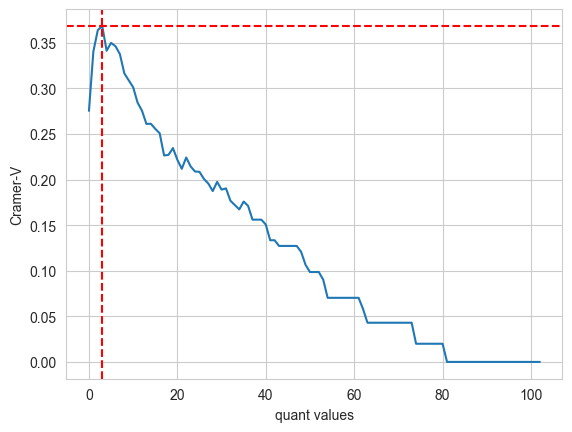

In [20]:
proxy_metrics.find_max_Cramer_V_threshold(data['last_3_contacts'], data['is_selling_2']=='Sold', plot = True, step = 1)

{'threshold': 1.4000000000000001, 'cramer_v_coefficient': 0.3686253838357947}

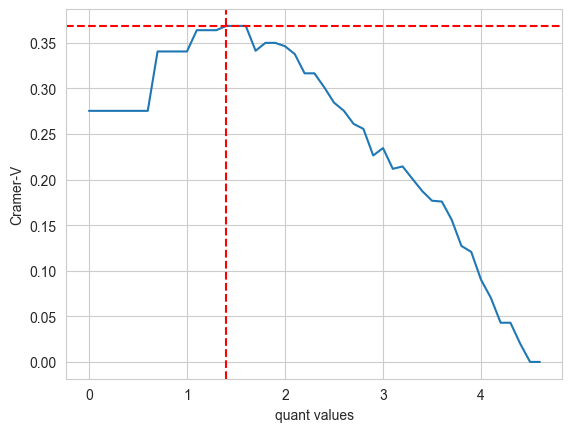

In [21]:
proxy_metrics.find_max_Cramer_V_threshold(np.log(data['last_3_contacts']+1), data['is_selling_2']=='Sold', plot = True, step = 0.1)

In [22]:
# преобразуем в исходную шкалу полученное рекомендованное значение
np.exp(1.4)-1

3.0551999668446745

Итак мы нашли, что по историческим данным наилучшая корреляция достигается при 3+ уровне контактов за 3 дня перед отправкой в архив

### Проверим чувствительность такой метрики для теста на конверсию

Помимо поиска корреляции, также необходимо находить еще и причинно-следственную связь. Все, что найдено на данный момент — это только высоко коррелированная метрика и пока нет уверенности в том, что она говорит о причинно-следственной связи, что, если действительно вырастет доля объявлений, которые набирают 3 контакта и выше, то вырастет и доля объявлений с проданными автомобилями и мы сможем эту метрику использовать в A/B-тесте. 

Это можно проверять разными способами, например, casual-inference методиками, либо A/B-тестом. В кейсе, который мы рассмотрим далее, есть A/B-тест. Этот A/B-тест — реально проведенный. Было влияние на приложение, где аналитики хотели понять, стала ли после введенного изменения на сайте выше доля тех объявлений, которые продаются. Также с тем, чтобы понять, стала ли выше доля продажи, был проведен дополнительный обзвон и вместе с этим отслеживалось, стала ли доля тех объявлений, которые набрали 3 и больше контакта выше в тестовой группе. Так мы сможем понять, действительно ли выбранная proxy-метрика помогает отвечать на вопросы о том, стала ли целевая метрика выше через proxy-метрику.

Для начала необходимо провести симуляции.

Проверка через А/Б-тест заключается в том, сможем ли мы находить реальные изменения в целевой метрике, наблюдая изменения в прокси-метрике.
Для этого необходим реально проведенный А/Б-тест, где есть найденное изменение в целевой метрике.
Либо, где эффекта в целевой метрике нет, и мы смотрим, как часто наша прокси метрика говорит, что эффект все-таки есть.

Возьмем имеющиеся исторические данные и будем каждый раз их разбивать на условные A и B группы, как будто бы у нас есть разбиение на A и B группы с платформы A/B-тестов. 

Имея это разбиение, мы будем пытаться назвать значение конверсии в продажу для контрольной и тестовой группы. Затем рассчитаем нужные значения для статистического критерия — количество наблюдений в группах A и B и количество случаев, в которых отслеживаемая метрика равна единице. Для этого мы задаемся вопросом: «В нашей бинарной маске по тем, кто продался сколько тех, кто продался в группе A и сколько в группе B?». Для количественной метрики: «Сколько объявлений, у которых контактов за последние три дня больше, чем пороговое значение?» Эти расчеты нужны для того, чтобы сделать тест на пропорцию, на долю. Чаще всего для этого используется z-тест, когда требуется проверить равенство долей в двух выборках. Код ниже дает ответ на вопрос, будет ли подобный тест на proxy-метрике или на целевой метрике выдерживать нужные значения уровня статистической значимости или же не будет:

### AA-test

In [23]:
# AA test simulation on target metric
# проведем симуляцию оценки равенства долей двумя способами. Непосредственно оценку доли проданных
# и оценку тех, кто набрал 3+ контактов за период до ухода в архив

aa_binary_ztest_pvalue_list = []
aa_quant_ztest_pvalue_list = []
quant_target_level = 3
n_sim = 1000

for i in range(1000):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = binary_mask_group_b.sum()
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = (quant_value_group_b >= quant_target_level).sum()

    #проведем z-test для оценки равенства долей в двух группах
    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b], nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b], nobs = [quant_nobs_group_a, quant_nobs_group_b])
    
    aa_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    aa_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_alpha_ci = proportion_confint((np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_alpha_ci = proportion_confint((np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Количество случаев ложного прокраса теста при оценке доли продавших:', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля продавших):', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших)', binary_alpha_ci)
print('------------------')
print('Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня:',(np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля набравших 3+):', (np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших)', quant_alpha_ci)

Количество случаев ложного прокраса теста при оценке доли продавших: 43
Уровень статистической значимости оценки (доля продавших): 0.043
99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших) (0.02647630095805954, 0.05952369904194045)
------------------
Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня: 56
Уровень статистической значимости оценки (доля набравших 3+): 0.056
99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших) (0.03727175464929014, 0.07472824535070986)


В доле продаж, нашей целевой метрике, уровень alpha выдерживается. Доверительный интервал для 1000 попыток таких испытаний — значения от 0.03 до 0.07. Это говорит о том, что proxy-метрику можно использовать так же, как и целевую метрику, потому что она помогает выдерживать уровень alpha.

Прежде всего будут важны такие значения, как мощность A/B-теста по целевой метрики и 99-процентный доверительный интервал для мощности. В целом, картина хорошая, которая и характерна для proxy-метрики: в proxy-метриках мощность даже выше. На данных по 1200 наблюдениям, если бы происходило использование не proxy-метрики, а целевой метрики, то 10-процентный эффект был бы обнаружен правильно даже в большем количестве случаев. Мощность выросла почти на 14 процентов потому что, как правило, proxy-метрики имеют более высокие значения долей и для них нужна меньшая выборка, чтобы обнаруживать эффект.

Проверка на исторических данных proxy-метрики завершена и есть понимание, что эту proxy-метрику можно использовать в z-тесте для определения того, стало ли лучше или нет. Это была проверка на исторических данных. Далее нам будут нужны реальные данные.

Как мы видим, уровень альфа на А/А-тестах выдерживается в заданных рамках. Посмотрим как будет вести себя на А/Б-симуляциях

In [24]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 1000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)
print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_alpha_ci)
print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)

Effect = 0.1
Sample size A group = 606
Sample size B group = 594
Target conversion A group =  0.3448844884488449
Target conversion B group =  0.37373737373737376
Proxy conversion A group =  0.4884488448844885
Proxy conversion B group =  0.5252525252525253
Мощность АБ-теста по целевой метрике 0.25
99%-процентный доверительный интервал для мощности (доля продавших) (0.02647630095805954, 0.05952369904194045)
Мощность АБ-теста по прокси метрике 0.393


Как мы видим, мощность теста по прокси-метрике немного выше, чем по основной. Связано это с различем в долях. Доля пользователей с кол-вом контактов больше или равно трех выше, чем тех, кто продал авто. Это разница влияет на то, какое кол-во пользователей нам необходимо, чтобы задетектить ожидаемый размер эффекта.
Поэтому на ограниченной выборке мы можем задетектить.

### Проверим, как ведет себя прокси метрика на реальном АБ-тесте

Мы решили использовать метрику "кол-во контактов за 3 дня до ухода в архив" как прокси-метрику для конверсии в продажу авто. По симуляциям метрика выглядела неплохо.

Теперь нам нужно проверить причинно-следственные связи на практике. Для этого проведем А/Б-тест, влияющий на набор контактов. И одновременно с ним будем проводить обзвон пользователей, ушедших в архив, чтобы определить, продали ли они автомобиль на самом деле.

Это позволит нам узнать истинный эффект от нововедения на долю продаваемых и эффект на набор контактов в последние 3 дня перед архивом.
Сопоставив эти два результата, мы поймем позволяет ли прокси-метрика находить эффекты на долю проданных авто.

Загрузим данные по АБ-тесту

In [25]:
ab_test_data = pd.read_csv('data/proxy_metrics_case_abtest.csv')
ab_test_data.head()

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,mumur_advertid,AB_test_group,is_selling_3
0,72,0,19,7,0,0,15,1,1,1,0.00,0,0,1228156847,0,0
1,2040,20,252,87,6,5,27,2,14,12,0.00,0,0,1111412596,1,1
2,4105,56,757,223,10,3,39,3,19,17,0.00,0,0,2292183779,1,0
3,4568,39,854,236,7,3,41,3,29,23,-0.17,2,-2,772897149,1,1
4,56,3,56,10,3,4,7,0,0,0,0.00,2,-1,1598865363,1,1


In [26]:
# посмотрим есть ли различия в доле продающих пользователей между двумя группами
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).mean())
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).mean())

0.3665997993981946
0.33732136922565636


Можно увидеть, что в группе, в которой были изменения в A/B-тесте, почти на 3 процента конверсия в продажу выросла. Посмотрим, как выглядит proxy-метрика: есть ли различия в доле набравших 3 контакта между двумя группами:

In [27]:
# посмотрим есть ли различия в доле пользователей, набравших больше 3 контактов между двумя группами
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).mean())
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).mean())

0.4745904379806085
0.4230641409106015


Действительно, здесь тоже есть различия: для группы, в которой были изменения доля тех, кто набрал больше 3 контактов составляет почти 47,5 процентов, а для тех, у кого изменений не было в контрольной группе оно всего 42 процента.

Это говорит о том, что proxy-метрика ведет себя сонаправленно с целевой метрикой.

Здесь пока мы не говорили о p-value и статистической значимости. Нам надо сделать статистический вывод. Нужно заметить, что при таком способе проверки, когда, например, есть обзвон, не всегда есть возможность гарантировать нужный объем выборки, чтобы обеспечить нужный уровень alpha и мощность для соответствующего MDE, поэтому, возможно, в нашем случае мощность будет не 0.8.

Даже беглый взгляд говорит, что мы можем детектить эффект и через прокси метрику. Давайте посмотрим, что скажут стат критерии.
Проведем тест для целевой метрики и посмотрим, какое значение будет у p-value:

In [28]:
# АБ-тест доли продавших
binary_counts_group_a = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).sum()
binary_counts_group_b = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).sum()

binary_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
binary_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

binary_z_score, binary_ztest_pvalue = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

print('Proportion abs uplift:', (binary_counts_group_b/binary_nobs_group_b) - (binary_counts_group_a/binary_nobs_group_a))
print('Proportion rel uplift:', (binary_counts_group_b/binary_nobs_group_b)/(binary_counts_group_a/binary_nobs_group_a) - 1)
print('Z-test p-value:', binary_ztest_pvalue)

Proportion abs uplift: 0.029278430172538228
Proportion rel uplift: 0.08679684373316987
Z-test p-value: 0.0007852964424626157


Можно заметить абсолютный эффект между конверсиями, его значение (0,029) составляет почти 3 процента. Если считать это значение относительно (0,086), то это почти 9% прироста. P-value низкое (0,0007), что говорит о том, что такие различия в долях не случайны.

Посмотрим такой же A/B-тест, но уже для доли набравших 3 и более контактов:

In [29]:
# АБ-тест доли набравших 3+
quant_counts_group_a = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).sum()
quant_counts_group_b = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).sum()

quant_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
quant_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

quant_z_score, quant_ztest_pvalue = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

print('Proportion abs uplift:', (quant_counts_group_b/quant_nobs_group_b) - (quant_counts_group_a/quant_nobs_group_a))
print('Proportion rel uplift:', (quant_counts_group_b/quant_nobs_group_b)/(quant_counts_group_a/quant_nobs_group_a) - 1)
print('Z-test p-value:', quant_ztest_pvalue)

Proportion abs uplift: 0.051526297070007
Proportion rel uplift: 0.12179310909949015
Z-test p-value: 1.3926986115308757e-08


Как мы видим в обоих метриках есть изменения в доле. Это говорит о том, что мы можем использовать  данную прокси-метрику для того, чтобы находить эффекты в целевой метрике.

Здесь прирост еще более высокий и составляет 5 процентов, а относительный uplift - 12 процентов. Это говорит о том, что proxy-метрика даже сильнее реагирует на нововведения и мы видим, что она дает тот же ответ, что и целевая метрика. Значит в следующих тестах, когда у нас уже не будет обзвонов, мы вполне сможем использовать proxy-метрику для того, чтобы утверждать, поможет ли нам этот A/B-тест или нововведение растить долю продающих объявлений на сайте.

Также стоит сказать, что еще существует закон Гудхарта и, например, через полгода данная proxy-метрика может перестать быть хорошей proxy-метрикой, поэтому важно периодически проводить корреляционный анализ и проверять, не испортилась ли она. Но теоретически сейчас было доказано, что proxy-метрика набора трех контактов и больше дает тот же ответ, что и целевая метрика и ее можно использовать в экспериментах.